In [1]:
from io import open
import glob, os, unicodedata, string

In [2]:
all_letters = string.ascii_letters + " .,'-"
n_letters = len(all_letters) + 1 # plus EOS marker

In [3]:
def findFiles(path): return glob.glob(path)

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
def read_lines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

In [6]:
category_lines = {}
all_categories = []
for filename in findFiles('/content/drive/MyDrive/datasets/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['French', 'Japanese', 'Italian', 'Greek', 'Korean', 'Scottish', 'Vietnamese', 'German', 'Irish', 'Chinese', 'Dutch', 'Spanish', 'English', 'Polish', 'Portuguese', 'Russian', 'Arabic', 'Czech']
O'Neal


In [7]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
rnn = RNN(n_letters, 128, n_letters)
rnn

RNN(
  (i2h): Linear(in_features=204, out_features=128, bias=True)
  (i2o): Linear(in_features=204, out_features=58, bias=True)
  (o2o): Linear(in_features=186, out_features=58, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax(dim=1)
)

In [9]:
import random

def random_choice(l): return l[random.randint(0, len(l) - 1)]
def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [10]:
def category_tensor(category): # one-hot vector for category
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def input_tensor(line): # one-hot matrix of first to last letters (not EOS) for input
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def target_tensor(line): # ``LongTensor`` of second letter to end (EOS) for target
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [15]:
def random_training_example():
    category, line = random_training_pair()
    cat_tensor = category_tensor(category)
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return cat_tensor, input_line_tensor, target_line_tensor

In [16]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.init_hidden()

    rnn.zero_grad()
    loss = torch.Tensor([0])

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [17]:
import time, math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

In [18]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter/n_iters*100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0

0m 15s (5000 5%) 2.7102
0m 30s (10000 10%) 3.0076
0m 46s (15000 15%) 2.6858
1m 2s (20000 20%) 3.2819
1m 17s (25000 25%) 2.4306
1m 32s (30000 30%) 2.7179
1m 47s (35000 35%) 3.0012
2m 2s (40000 40%) 2.5107
2m 18s (45000 45%) 3.5882
2m 35s (50000 50%) 2.8215
2m 50s (55000 55%) 1.6898
3m 5s (60000 60%) 2.3565
3m 20s (65000 65%) 1.8451
3m 37s (70000 70%) 1.9742
3m 53s (75000 75%) 2.0076
4m 8s (80000 80%) 2.0419
4m 23s (85000 85%) 2.8915
4m 39s (90000 90%) 2.6838
4m 55s (95000 95%) 2.1339
5m 10s (100000 100%) 2.3012


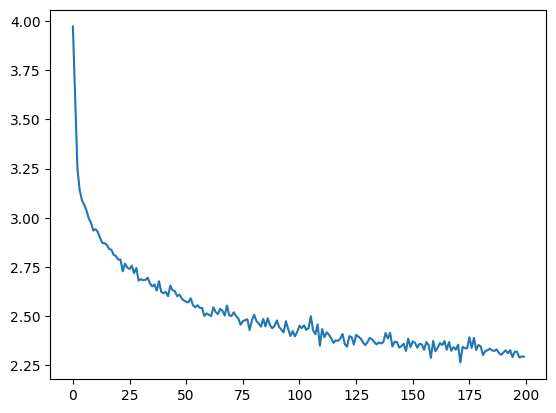

In [20]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses);

In [27]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():
        cat_tensor = category_tensor(category)
        input = input_tensor(start_letter)
        hidden = rnn.init_hidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(cat_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = input_tensor(letter)
        return output_name

In [28]:
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [33]:
samples('Russian', 'RUSSIAN')

Rovakov
Uorakov
Shakav
Shakav
Iakin
Antovovev
Nakan


In [30]:
samples('Irish', 'CTD')

China
Tanan
Dangan


In [32]:
samples('German', 'AUR')

Arter
Uren
Roulle
